In [1]:
import sys
sys.path.insert(0, "../")
from datetime import datetime
import rebound
import numpy as np
import matplotlib.pyplot as plt
from src.utilities.constants import rad2Deg, m2au, sec2year

In [2]:
def sim_init():
    sim = rebound.Simulation()
    sim.units = ('s', 'm', 'Kg')
    G = sim.G

    sim.add(m=1.3271244004193938e20/G)
    
    a = 329320844896.02423 # m 
    e = 0.15585014794810317
    i = 5.889091687694949/rad2Deg
    Om = 110.87633970146754/rad2Deg
    om = 285.50181319194064/rad2Deg
    M  = 15.638508490829182/rad2Deg
    sim.add(a = a, e = e, inc = i, Omega = Om, omega = om, M = M, hash = 'Flora')
    return sim

In [3]:
sim = sim_init()
sim.integrator = 'mercurius'
ps = sim.particles
sim.dt = .005*ps[1].P
data = {'a':[], 'e':[], 'ax':[], 'ay':[]}
tmax = 1e6*sec2year
ts = np.linspace(0, tmax, 200)
t_start = datetime.now()
for t in ts:
    sim.integrate(t)
    data['a'].append(ps[1].a*m2au)
    data['e'].append(ps[1].e)
    data['ax'].append(ps[1].ax)
    data['ay'].append(ps[1].ay)
t_end = datetime.now()
print(t_end - t_start)

0:00:31.638194


3.584688101909705e-12

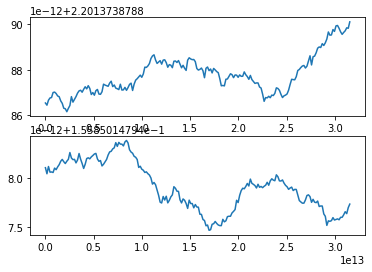

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ts, data['a'])
ax2.plot(ts, data['e'])
au_myr = abs(data['a'][0] - data['a'][-1])/(tmax/sec2year)*1e6
au_myr

In [5]:
def radial_force(reb_sim):
    sim = reb_sim.contents
    ps = sim.particles
    a = .001/ps[1].d**2
    x, y, z = ps[1].xyz
    ps[1].ax += a*-1*y/np.linalg.norm(ps[1].xyz)
    ps[1].ay += a*x/np.linalg.norm(ps[1].xyz)

def starkForce(reb_sim):
    c = 0.01
    sim = reb_sim.contents
    ps = sim.particles
    ps[1].ax += c

def pr_drag(reb_sim):
    sim = reb_sim.contents
    ps = sim.particles
    star = ps[0]
    c = 2.998e+06
    G = sim.G
    for i, p in enumerate(ps[:]):
        if p.m >0:
            continue
        prx  = p.x-star.x
        pry  = p.y-star.y
        prz  = p.z-star.z
        pr   = np.sqrt(prx*prx + pry*pry + prz*prz)

        prvx = p.vx-star.vx
        prvy = p.vy-star.vy
        prvz = p.vz-star.vz

        rdot = (prvx*prx + prvy*pry + prvz*prz)/pr
        f = 3.321012071791588e-09
        F_r     = f*G*star.m/(pr*pr)

        sign = 1
        
        ps[i].ax += F_r*(sign * prvx/c)
        ps[i].ay += F_r*(sign * prvy/c)
        ps[i].az += F_r*(sign * prvz/c)

In [6]:
sim = sim_init()
sim.integrator = 'mercurius'
ps = sim.particles
sim.dt = .005*ps[1].P
sim.additional_forces = pr_drag
sim.force_is_velocity_dependent = True

0:52:50.979337


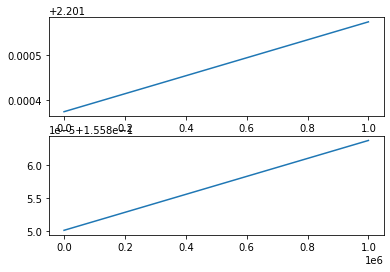

In [7]:
data_addf = {'a':[], 'e':[], 'ax':[], 'ay':[]}
t_start = datetime.now()
for t in ts:
    sim.integrate(t)
    data_addf['a'].append(ps[1].a*m2au)
    data_addf['e'].append(ps[1].e)
    data_addf['ax'].append(ps[1].ax)
    data_addf['ay'].append(ps[1].ay)
t_end = datetime.now()
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ts/sec2year, data_addf['a'])
ax2.plot(ts/sec2year, data_addf['e'])
print(t_end - t_start)

0.0002000167190456814

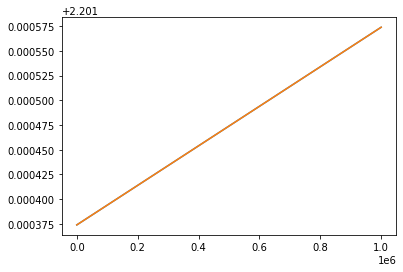

In [8]:
plt.plot(ts/sec2year, data_addf['a'])
plt.plot([0, max(ts)/sec2year], [data_addf['a'][0], max(data_addf['a'])])
au_myr = abs(data_addf['a'][0] - max(data_addf['a']))/(tmax/sec2year)*1e6
au_myr

In [46]:
f=new_f
target = 2e-4

new_f = target*f/au_myr
new_f

3.321012071791588e-09

In [59]:
e_myr = abs(data_addf['e'][0] - max(data_addf['e']))/(tmax/sec2year)*1e6
e_myr

1.3486344488389257e-05

In [74]:
33.5*1e2/60

55.833333333333336

In [ ]:
# ias15 took 148s to run 10kyrs: ~4h10min for 1Myr,  ~25 weeks for 1Gyr
# mercurius took 33s to run 10kyrs: ~56min for 1Myr, ~5 weeks for 1 Gyr